In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load('mnist', split='train', as_supervised=True, shuffle_files=True )

In [3]:
def add_noise(img,factor=0.22):  
  img = img + (np.random.randn(*img.shape))*factor
  img = img.clip(0.,1.)
  return img 

In [26]:
x = []
y = []
itr=0
for ex in ds:
  itr+=1
  img,_= ex
  img = img.numpy().astype('float')/255.0
  n_img = add_noise(img)
  x.append(n_img)
  y.append(img)
  # if itr==10000:
  #   break
    
x = np.array(x)
y = np.array(y)

print('Number of images in dataset:',x.shape[0])
print('Shape of image:',x.shape[1:])


Number of images in dataset: 60000
Shape of image: (28, 28, 1)


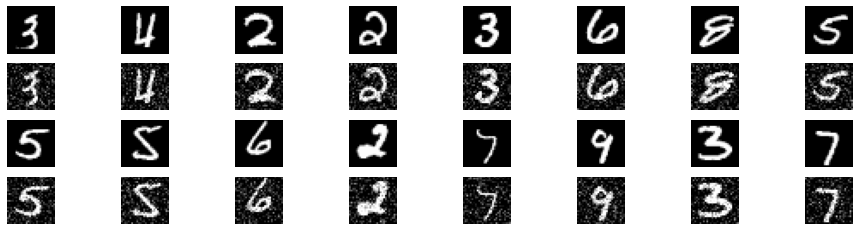

In [28]:
# mnist images
rows = 2
cols = 8
seed = np.random.randint(1,500)
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols ,subplot_size*rows))
for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
    plt.imshow(y[seed+(i*cols+j)].reshape(28,28),cmap='gray')
    plt.axis('off')
  for j in range(cols):
    f.add_subplot(rows*2,cols, ((2*i+1)*cols)+(j+1))
    plt.imshow(x[seed+(i*cols+j)].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.savefig('digits_orig.png')

In [6]:
split_size = int(0.8 * (x.shape[0]))

x_train,y_train = x[:split_size],y[:split_size]
x_valid,y_valid = x[split_size:],y[split_size:]

print('Training dataset shape:',x_train.shape)
print('Validation dataset shape:',x_valid.shape)

Training dataset shape: (48000, 28, 28, 1)
Validation dataset shape: (12000, 28, 28, 1)


In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64,(5,5),activation='relu',input_shape=(28,28,1), padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same'),
  tf.keras.layers.Conv2DTranspose(16,(3,3), padding='same',activation='relu'),
  tf.keras.layers.UpSampling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2DTranspose(32,(3,3), padding='same',activation='relu'),
  tf.keras.layers.UpSampling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2DTranspose(32,(5,5), padding='same',activation='relu'),
  tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 16)          2

In [8]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=8, verbose=1)
# op = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = model.fit(y_train,y_train, validation_data=(y_valid,y_valid), epochs=500, batch_size=256, callbacks=[reduce_lr,early_stopping], verbose=1)

Epoch 1/500
188/188 [==============================] - 5s 24ms/step - loss: 0.1763 - val_loss: 0.1178
Epoch 2/500
188/188 [==============================] - 4s 22ms/step - loss: 0.1098 - val_loss: 0.0959
Epoch 3/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0997 - val_loss: 0.0857
Epoch 4/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0943 - val_loss: 0.0829
Epoch 5/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0908 - val_loss: 0.0794
Epoch 6/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0882 - val_loss: 0.0788
Epoch 7/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0864 - val_loss: 0.0768
Epoch 8/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0848 - val_loss: 0.0757
Epoch 9/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0837 - val_loss: 0.0756
Epoch 10/500
188/188 [==============================] - 4s 22ms/step - loss: 0.082

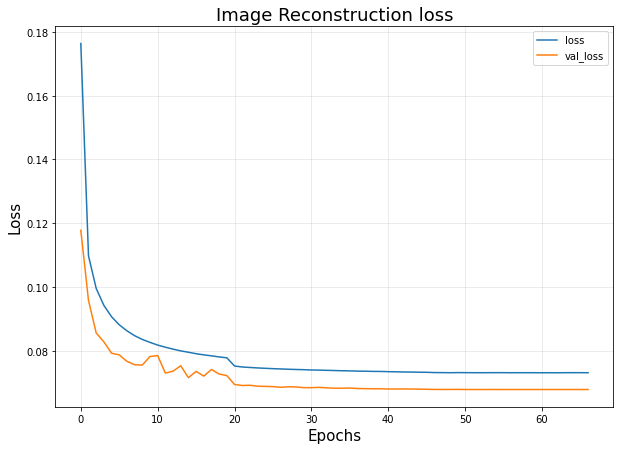

In [9]:
# image reconstruction loss
f = plt.figure(figsize=(10,7))
f.add_subplot()

plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'], label='val_loss')
plt.title('Image Reconstruction loss', fontsize=18)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('image_reconstruction_loss.png')
plt.show()

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=3, min_lr=1e-5,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping('loss', patience=5, verbose=1)
# op = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = model.fit(x_train,y_train, validation_data=(x_valid,y_valid), epochs=500, batch_size=256, callbacks=[reduce_lr,early_stopping], verbose=1)

Epoch 1/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0868 - val_loss: 0.0779
Epoch 2/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0836 - val_loss: 0.0774
Epoch 3/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0830 - val_loss: 0.0772
Epoch 4/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0827 - val_loss: 0.0768
Epoch 5/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0824 - val_loss: 0.0782
Epoch 6/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0821 - val_loss: 0.0769
Epoch 7/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0820 - val_loss: 0.0775
Epoch 8/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0818 - val_loss: 0.0766
Epoch 9/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0816 - val_loss: 0.0762
Epoch 10/500
188/188 [==============================] - 4s 22ms/step - loss: 0.081

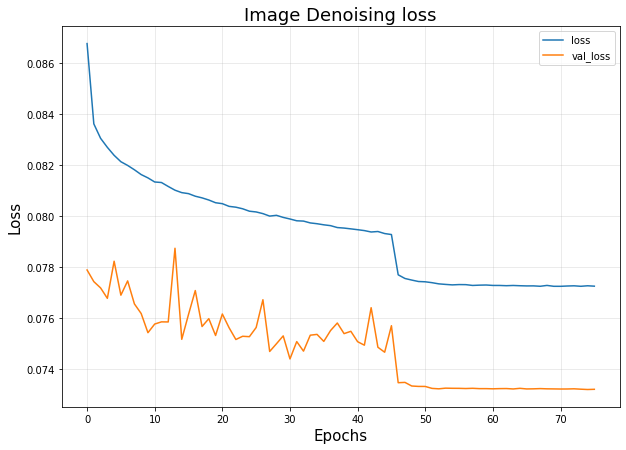

In [11]:
# image denoising loss
f = plt.figure(figsize=(10,7))
f.add_subplot()

plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'], label='val_loss')
plt.title('Image Denoising loss', fontsize=18)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('image_denoising_loss.png')
plt.show()

In [12]:
model.save('MNIST_AE_weights.h5')

In [13]:
# Sample few test images
seed = np.random.randint(1,500)
x = x_valid[seed:(seed+8)]
yy = y_valid[seed:(seed+8)]
y_hat =model.predict(x)

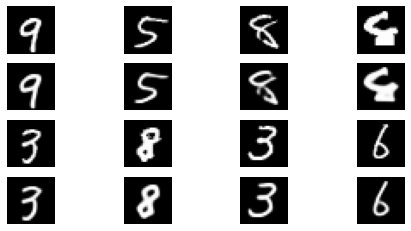

In [16]:
# mnist images
rows = 2
cols = 4
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols ,subplot_size*rows))
for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
    plt.imshow(yy[i*cols+j].reshape(28,28),cmap='gray')
    plt.axis('off')
  for j in range(cols):
    f.add_subplot(rows*2,cols, ((2*i+1)*cols)+(j+1))
    plt.imshow(y_hat[i*cols+j].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.savefig('digits_predict.png')